<a href="https://colab.research.google.com/github/pujashah14/pneumonia-classifier/blob/master/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip show tensorflow

Name: tensorflow
Version: 1.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: gast, google-pasta, keras-applications, tensorflow-estimator, keras-preprocessing, numpy, wrapt, absl-py, six, protobuf, wheel, opt-einsum, tensorboard, termcolor, grpcio, astor
Required-by: stable-baselines, magenta, fancyimpute


In [0]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline

from keras.applications import VGG19, ResNet50
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import random
import cv2
import urllib.request
import tarfile

# Deep learning libraries
import keras.backend as K

import tensorflow as tf
import glob

In [0]:
if not os.path.exists('./data/chest_xray'):
    os.makedirs('./data', exist_ok=True)
    urllib.request.urlretrieve("https://s3.eu-central-1.amazonaws.com/public.unit8.co/data/chest_xray.tar.gz", "data/chest_xray.tar.gz")
    tar = tarfile.open("data/chest_xray.tar.gz")
    tar.extractall(path='./data/')
    os.remove('data/chest_xray.tar.gz')

In [0]:
glob.glob('./data/chest_xray/*/*')

['./data/chest_xray/val/PNEUMONIA',
 './data/chest_xray/val/NORMAL',
 './data/chest_xray/train/PNEUMONIA',
 './data/chest_xray/train/NORMAL',
 './data/chest_xray/test/PNEUMONIA',
 './data/chest_xray/test/NORMAL']

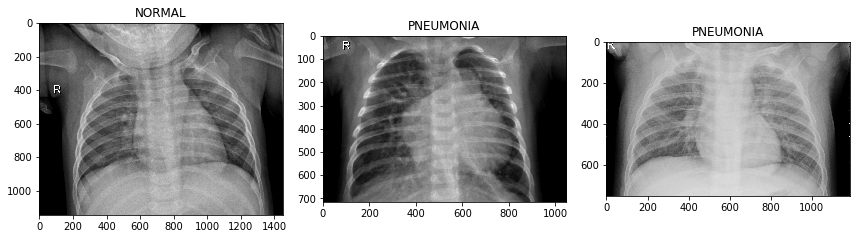

In [0]:
img_normal = plt.imread('./data/chest_xray/train/NORMAL/IM-0131-0001.jpeg')
img_penumonia_bacteria = plt.imread('./data/chest_xray/train/PNEUMONIA/person1017_bacteria_2948.jpeg')
img_penumonia_virus = plt.imread('./data/chest_xray/train/PNEUMONIA/person1021_virus_1711.jpeg')

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

In [0]:
input_path = './data/chest_xray/'

In [0]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [0]:
img_dims = 150
epochs = 20
batch_size = 32

# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
# Input layer
inputs = Input(shape=(img_dims, img_dims, 3))

base_model=VGG19(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

80142336/80134624 [==============================] - 2s 0us/step
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_9 (Separabl (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_10 (Separab (None, 75, 75, 32)        1344      
____________________________________________________________

In [0]:
#Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

# Fitting the model
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])



Epoch 1/5
163/163 [==============================] - 354s 2s/step - loss: 0.3703 - acc: 0.8330 - val_loss: 3.1681 - val_acc: 0.3783
Epoch 2/5
163/163 [==============================] - 345s 2s/step - loss: 0.2760 - acc: 0.8850 - val_loss: 1.0114 - val_acc: 0.4122
Epoch 3/5
163/163 [==============================] - 344s 2s/step - loss: 0.2727 - acc: 0.8936 - val_loss: 0.3994 - val_acc: 0.8176

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/5
163/163 [==============================] - 344s 2s/step - loss: 0.2090 - acc: 0.9233 - val_loss: 0.2492 - val_acc: 0.9105
Epoch 5/5
163/163 [==============================] - 345s 2s/step - loss: 0.1982 - acc: 0.9252 - val_loss: 0.7043 - val_acc: 0.6824

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.


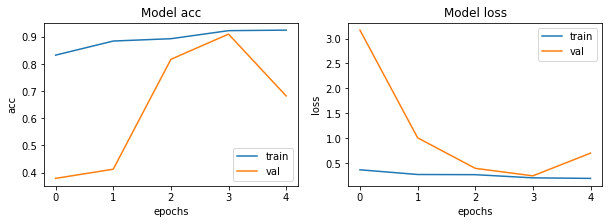

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


TEST METRICS ----------------------
Accuracy: 67.78846153846155%
Precision: 97.48743718592965%
Recall: 49.743589743589745%
F1-score: 65.87436332767403

TRAIN METRIC ----------------------
Train acc: 92.52

CONFUSION MATRIX ------------------
[[229   5]
 [196 194]]


<function matplotlib.pyplot.show>

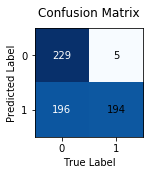

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['acc'][-1])*100, 2)))

print('\nCONFUSION MATRIX ------------------')
print(cm)
plot_confusion_matrix(conf_mat = cm, figsize = (2,2))
plt.title('Confusion Matrix')
plt.ylabel('Predicted Label')
plt.xlabel('True Label')
plt.show

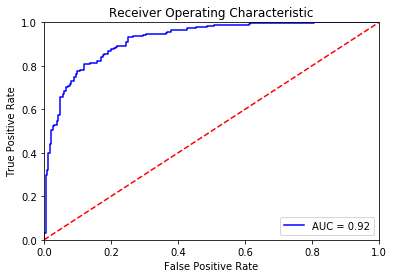

In [0]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(test_labels, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
